## 1 Importing libraries

In [3]:
import pandas as pd
import joblib
import sklearn
import numpy as np
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer


# DatetimeFeatures uses pandas.to_datetime to convert object variables to datetime
# and pandas.dt to extract the features from datetime.
from feature_engine.datetime import DatetimeFeatures 



from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  learning_curve

from sklearn.pipeline import Pipeline

# 2. Display setting

In [5]:
pd.set_option("display.max_columns", None)

In [6]:
sklearn.set_config(transform_output="pandas")

## 3.Getting the data

In [8]:
train_df = pd.read_csv("data/train (1).csv")
test_df = pd.read_csv("data/test.csv")
val_df = pd.read_csv("data/val.csv")

In [9]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


## 3.1 Split the data

In [11]:
def split_data(data) :

    x = data.drop(columns="price")
    y = data.price.copy()

    return(x , y )
    

In [12]:
x_train , y_train = split_data(train_df)

In [13]:
x_train 

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [14]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [15]:
x_val , y_val = split_data(val_df)
print(x_val.shape , y_val.shape)

(160, 9) (160,)


In [16]:
x_test , y_test = split_data(test_df)
print(x_test.shape , y_test.shape)

(200, 9) (200,)


## 3.2 Meta-info

In [18]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4 Data preprocessing

In [20]:
num_cols = ["duration" , "total_stops"]

date_cols = ["date_of_journey" ]
time_cols = ["arrival_time", "dep_time"]

# [expression for item in iterable if condition]
categ_cols = [i for i in x_train.columns if (i not in num_cols) and (i not in date_cols) and (i not in time_cols) ]


In [21]:
categ_cols

['airline', 'source', 'destination', 'additional_info']

In [22]:
x_train["date_of_journey"] = x_train["date_of_journey"].astype(str)
x_train["dep_time"] = x_train["dep_time"].astype(str)
x_train["arrival_time"] = x_train["arrival_time"].astype(str)



In [23]:
# missing values, so apply the mode i.e most_frequent

num_transformer= Pipeline(steps = [("imputer",SimpleImputer(strategy="median") ) , 
                             ("scaler",StandardScaler() ) ] )

cat_transformer = Pipeline(steps = [( "imputer" ,SimpleImputer(strategy="most_frequent") ) ,
                             ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore") )  ] )

               

dojourney_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(
        variables=[ "date_of_journey"],  # <-- use your actual datetime column name
        features_to_extract=["month", "week", "year", "day_of_week", "day_of_month"]
    )),
    ("scaler", StandardScaler())
])

# For time column like 'departure_time'
time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(
        variables=["arrival_time" , "dep_time"],  # <-- use your actual time column name
        features_to_extract=["hour", "minute", "second"]
    )),
    ("scaler", StandardScaler())
])

                                                                              

In [24]:
preprocessor = ColumnTransformer(transformers=[("num" , num_transformer , num_cols) ,
                ("cat" , cat_transformer , categ_cols) , ("doj" , dojourney_transformer , date_cols) 
                ,("time" , time_transformer , time_cols)
        
                                              ])  


In [25]:
preprocessor.fit_transform(x_train)

C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_year,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__arrival_time_hour,time__arrival_time_minute,time__arrival_time_second,time__dep_time_hour,time__dep_time_minute,time__dep_time_second
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.0,0.566118,0.963554,-0.345231,1.493859,0.0,-0.462055,-0.140057,0.0
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,0.0,1.050498,0.604465,-0.935607,0.891041,0.0,-0.640951,-1.229863,0.0
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,0.0,-0.402640,-0.113711,-0.345231,-1.218823,0.0,-0.640951,-0.684960,0.0
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,0.0,-1.371399,-1.430369,1.278301,1.795268,0.0,1.326906,-0.140057,0.0
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.0,0.081739,-0.831888,-0.492825,1.192450,0.0,0.790218,-1.229863,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.0,0.566118,-0.113711,-0.935607,1.192450,0.0,-1.535432,1.767103,0.0
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.0,0.081739,-0.472800,1.130707,-1.218823,0.0,-0.640951,0.677297,0.0
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,0.0,-0.402640,0.245377,-0.788013,1.493859,0.0,-1.177640,-0.957412,0.0
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,0.0,-0.402640,0.245377,1.130707,-1.520232,0.0,-0.819847,1.222200,0.0


## 5. Model Selection





In [27]:
algo = {
    "LinearRegression"  : LinearRegression(),
    "support vector machine" : SVR() ,
    "Random Forest " : RandomForestRegressor(n_estimators=10),
    "XG_Boost" : XGBRegressor(n_estimators=10)
}

In [28]:
data = pd.concat([train_df , val_df])                # bydefault axis=0

x_data , y_data = split_data(data)
print(x_data.shape , y_data.shape)


(800, 9) (800,)


In [29]:
def plot_curve(sizes , mean_scores , std_scores , lab , ax) :
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label = lab
    )
    ax.fill_between(
        sizes,
        mean_scores - std_scores,
        mean_scores + std_scores,

        alpha = 0.5
    )


In [30]:
def plot_learning_curve(name, algorithm, x_data, y_data, preprocessor, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("prep", preprocessor),
        ("alg", algorithm),
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=x_data,
        y=y_data,
        cv=3,
        n_jobs=-1
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    # training curve
    plot_curve(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    # test curve
    plot_curve(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")
    plt.show()


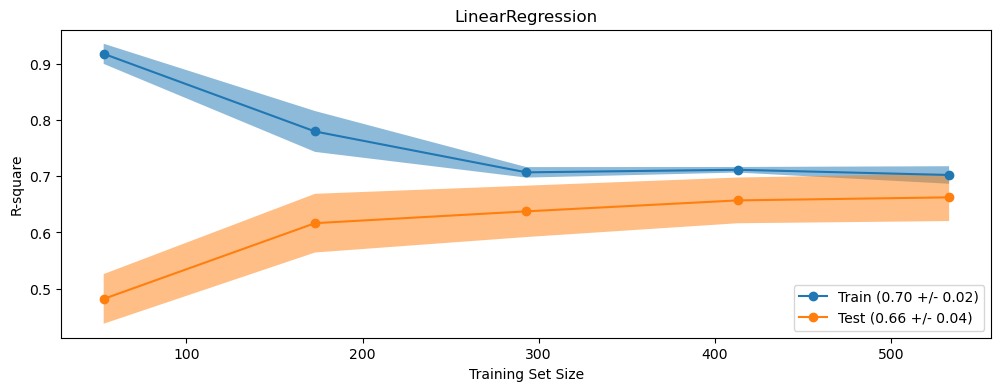

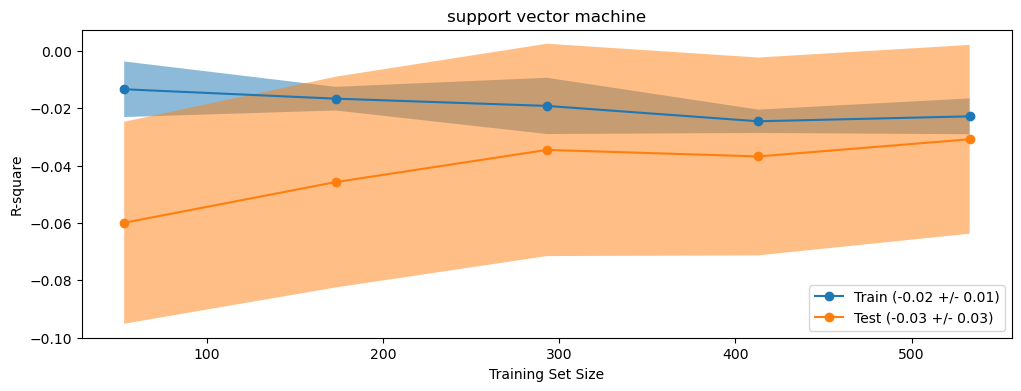

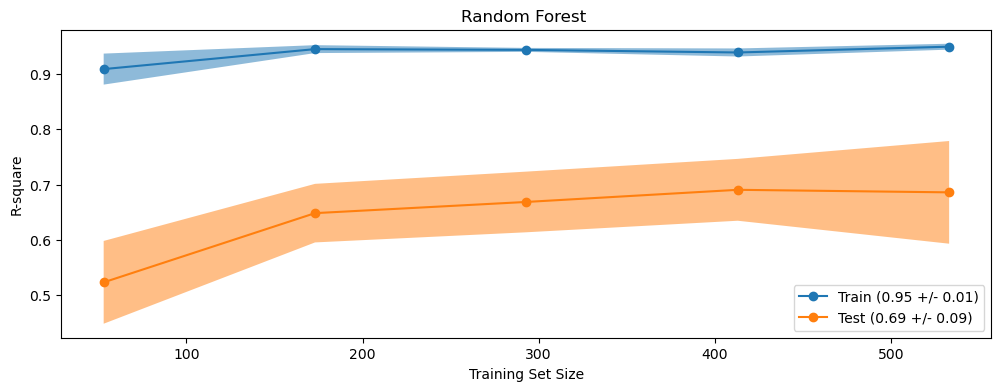

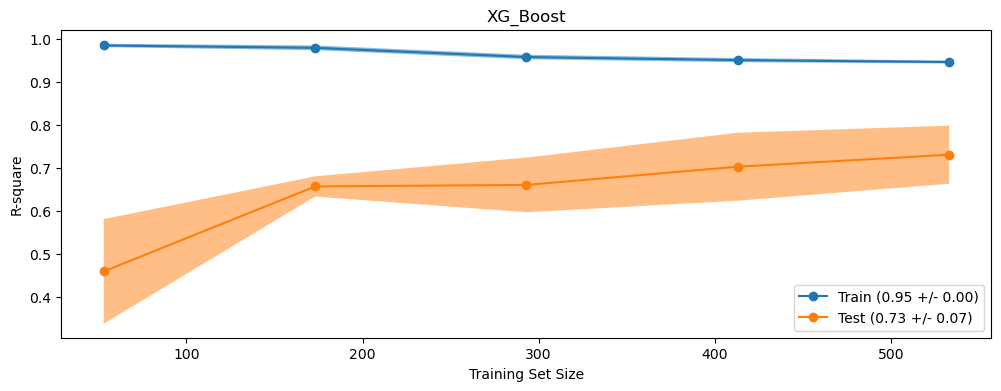

In [31]:
for name, algorithm in algo.items():
    plot_learning_curve(name, algorithm, x_data, y_data, preprocessor)


### 6.Model Training


In [33]:
model = Pipeline(steps=[
    ("pre" , preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10))
])

In [34]:
model.fit(x_data , y_data)

C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute',
                                                                                                         'second'],
                                                                                    variables=['arrival_time',
                                                                                               'dep_time'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['arrival_time',
                                                   'dep_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

### 7. Model Evaluation

In [36]:
def  evaluate_model(x,y) : 
    y_pred = model.predict(x)
    return r2_score(y,y_pred)

In [37]:
print(f" R2 score on training data is= {evaluate_model( x_data,y_data) }")

 R2 score on training data is= 0.9554535002892364


C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


In [38]:
print(f" R2 score on test data is= {evaluate_model( x_test,y_test) }")

 R2 score on test data is= 0.6408476900356499


C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


## 8. Model Persistence

In [40]:
joblib.dump(model , "model.joblib")

['model.joblib']

In [41]:
saved_model = joblib.load("model.joblib")

In [42]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute',
                                                                                                         'second'],
                                                                                    variables=['arrival_time',
                                                                                               'dep_time'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['arrival_time',
                                                   'dep_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [43]:
y_pred = saved_model.predict(x_test)
r2_score(y_test,y_pred)

C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\impar\anaconda3\envs\flask_ml\lib\site-packages\feature_engine\datetime\datetime.py:347: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


0.6408476900356499